# EDA on the Official Covid-19 Public Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from itertools import chain
import datetime as dt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

pd.set_option('display.max_columns', None)

## Epidemic

## Loading the Epidemic Dataset

In [2]:
cases_malaysia = pd.read_csv('covid19-public/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('covid19-public/epidemic/cases_state.csv')
clusters = pd.read_csv('covid19-public/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('covid19-public/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('covid19-public/epidemic/deaths_state.csv')
hospital = pd.read_csv('covid19-public/epidemic/hospital.csv')
icu = pd.read_csv('covid19-public/epidemic/icu.csv')
pkrc = pd.read_csv('covid19-public/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('covid19-public/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('covid19-public/epidemic/tests_state.csv')

In [5]:
population = pd.read_csv('covid19-public/static/population.csv')

We will start by looking at the cases_malaysia dataset first.

In [ ]:
print(cases_malaysia.shape)
cases_malaysia.dtypes

In [ ]:
cases_malaysia.isnull().sum()

In [ ]:
print(cases_state.shape)
cases_state.dtypes

In [ ]:
cases_state.isnull().sum()

In [ ]:
print(clusters.shape)
clusters.dtypes

In [ ]:
clusters.isnull().sum()

In [ ]:
print(deaths_malaysia.shape)
deaths_malaysia.dtypes

In [ ]:
print(deaths_state.shape)
deaths_state.dtypes

In [ ]:
deaths_state.isnull().sum()

In [ ]:
print(hospital.shape)
hospital.dtypes

In [ ]:
hospital.isnull().sum()

In [ ]:
print(icu.shape)
icu.dtypes

In [ ]:
icu.isnull().sum()

In [ ]:
print(pkrc.shape)
pkrc.dtypes

In [ ]:
pkrc.isnull().sum()

In [ ]:
print(tests_malaysia.shape)
tests_malaysia.dtypes

In [ ]:
tests_malaysia.isnull().sum()

In [ ]:
print(tests_state.shape)
tests_state.dtypes

In [ ]:
tests_state.isnull().sum()

In [ ]:
print(population.shape)
population.dtypes

In [ ]:
population.isnull().sum()

In [ ]:
# Basic preperation

# change to date_time from object
cases_malaysia['date'] = pd.to_datetime(cases_malaysia['date'], errors='raise')
cases_state['date'] = pd.to_datetime(cases_state['date'], errors='raise')
clusters['date_announced'] = pd.to_datetime(clusters['date_announced'], errors='raise')
clusters['date_last_onset'] = pd.to_datetime(clusters['date_last_onset'], errors='raise')
deaths_malaysia['date'] = pd.to_datetime(deaths_malaysia['date'], errors='raise')
deaths_state['date'] = pd.to_datetime(deaths_state['date'], errors='raise')
hospital['date'] = pd.to_datetime(hospital['date'], errors='raise')
icu['date'] = pd.to_datetime(icu['date'], errors='raise')
pkrc['date'] = pd.to_datetime(pkrc['date'], errors='raise')
tests_malaysia['date'] = pd.to_datetime(tests_malaysia['date'], errors='raise')
tests_state['date'] = pd.to_datetime(tests_state['date'], errors='raise')

## Measuring the Central Tendency of the Datasets

In [ ]:
display(cases_malaysia.describe())
display(cases_state.describe())
display(clusters.describe())
display(deaths_malaysia.describe())
display(deaths_state.describe())
display(hospital.describe())
display(icu.describe())
display(pkrc.describe())
display(tests_malaysia.describe())
display(tests_state.describe())
display(population.describe())

## cases_malaysia.csv dataset

Under the `cases_malaysia` dataset, we can subset it further. These subset groups are: 
- Age group: `cases_child`, `cases_adolescent`, `cases_adult`, `cases_elderly`
- Cases from identified clusters: `cluster_religious`, `cluster_community`, `cluster_highRisk`, `cluster_education`, `cluster_detentionCentre`, `cluster_workplace` 

The same can be seen for the `cases_state` dataset, which only has the age group subset. 

These subsets can be used for our analysis on differences between the age groups, as well as the clusters they are likely to originate from. This may have potential for identifying patterns or data for mining in terms of which age group/clusters the Covid-19 cases originate from. 

We also need to note that, the "Cases from Identified Clusters" has a huge amount of null values. Further inspection reveals that, the values that are null, originate from the dates that appear before '1/1/2021', where there is no recorded data regarding daily cases from clusters. Hence, it would be a viable option to analyse this group, after this specified date (1/1/2021). 

In [ ]:
# Prove that the dataset is null before 01/01/2021, uncomment the code below
cases_malaysia.iloc[340:344]

Finally, since the `cases_cluster` column represents the cases attributed to the clusters, and we are interested now to see the general pattern of the new cases in Malaysia, we shall drop the columns in the group of 'Cases from identified clusters'.

In [ ]:
# save the clusters into another dataframe
cases_malaysia_with_clusters = cases_malaysia[['date', 'cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace']].copy()
cases_malaysia_with_clusters

In [ ]:
# For dropping clusters 
cases_malaysia.drop(cases_malaysia.columns[12:], axis=1, inplace=True)

In [ ]:
sns.pairplot(data=cases_malaysia)

In [ ]:
# show the correlation between attributes using a correlation plot
sns.set(rc={'figure.figsize':(15,9)})
sns.heatmap(cases_malaysia[1:-1].corr().round(2), cmap='Blues', annot=True, vmin=0, vmax=1)

From this correlation plot, with the exception of `cases_import`, each attribute is strong positive correlation to another attribute. Now we look at the histogram and density plot for these attributes. 

In [ ]:
coi = cases_malaysia.columns.tolist()
coi.pop(0)
for column in coi: 
    print("Skewness " + column + ": " + str(cases_malaysia[column].skew()))

Based on the value of the skewness, we can see that all of these attributes are highly skewed to the right. To reduce this skewness, we will be employing cube square root transform, which is normally applied for counted data. 

In [ ]:
for column in coi: 
    fig, ax = plt.subplots(figsize=(5,5))
    sqrt_trans = np.sqrt(cases_malaysia[column])
    sns.histplot(ax=ax, data=sqrt_trans, kde=True, bins=20)
    plt.show()

For identifying outliers in this data, the appropriate graph to be used will be to use will be the boxplot. 

In [ ]:
for column in coi: 
    fig, ax = plt.subplots(figsize=(5,3))
    ax.set_title(column)
    sns.boxplot(ax=ax, data=cases_malaysia[column], orient='h', palette='Set1')
    plt.show()

Based on the analysis of the outliers, we can see that the `cases_active` has a very wide range of values. In order to better analyse the other attributes, we will be removing the `cases_active` attribute so that we may further study the other attributes in the column. 

However, we also notice that many other attributes still contain a high amount of outliers. In order to overcome this problem, we will split our dataset into 3-month intervals for this boxplot analysis. 

In [ ]:
coi.pop(3)

intervals_boundries = [pd.Timestamp('2020-01-25'), 
                        pd.Timestamp('2020-04-25'), 
                        pd.Timestamp('2020-07-25'),
                        pd.Timestamp('2020-10-25'),
                        pd.Timestamp('2021-01-25'),
                        pd.Timestamp('2021-04-25'), 
                        pd.Timestamp('2021-07-25'),
                        pd.Timestamp('2021-10-25'),]

In [ ]:
cases_malaysia.set_index('date', inplace=True)
n_plots = len(intervals_boundries) - 1

fig, axes = plt.subplots(ncols=2, nrows=n_plots//2, figsize=(16,10))

for i, ax in zip(range(len(intervals_boundries)), axes.flat):
    ax.set_title(intervals_boundries[i].strftime('%Y-%m-%d') + ' to ' + intervals_boundries[i+1].strftime('%Y-%m-%d'))
    df = cases_malaysia.loc[intervals_boundries[i]:intervals_boundries[i+1],coi]
    sns.boxplot(data=df, orient='h', palette='Set1', ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(7,3))
ax.set_title(intervals_boundries[-2].strftime('%Y-%m-%d') + ' to ' + intervals_boundries[-1].strftime('%Y-%m-%d'))
df = cases_malaysia.loc[intervals_boundries[-2]:intervals_boundries[-1],coi]
sns.boxplot(ax=ax, data=df, orient='h', palette='Set1')
plt.show()

After splitting the datasets into 3-month intervals, we have successfully reduced the outliers across all attributes. Further analysis shows that, `cases_new`, `cases_recovered` and `cases_adult` cover the widest range. The outliers indicates that, along the 3-month intervals, we have a spike in cases that attributed to the existence of these upper outliers when recording the daily cases in Malaysia, which subsequently led to the wide range of values in the `cases_recovery` attribute, as more people recovered from their Covid-19 infection. 

The strongest indicator however, is that a majority of the cases originates from adults. Hence, this category group should be the main focus of the government if it plans to curb and control the spread of Covid-19 in Malaysia.

## Feature Engineering: Lagging and Rolling Average for Daily New Cases
As we are dealing with time series analysis data, we will need to expand the number of features, for the purposes of feature extraction. One of the few methods we chose to approach is by using lagged variables i.e how past values of variables are able to influence the future values, thus unlocking predictive value. 

The second method involes using a moving average, in the form of a 7-day moving average and 14-day moving average. The reason we use this method is because it is extremely difficult to understand how much something is increasing when there are multiple peaks and valleys, espeically when looking at relational plots. In our case, it provides us with an average line over time, which effectively 'flattens' the peaks and valleys, giving us a better visualisation for example, the trend of daily cases. 

Below, we have prepared 2 functions that help us perform the above tasks before we conduct feature extraction of the variables. We will be using these functions for the `cases_malaysia` and `cases_state` dataset.

In [ ]:
def calc_lag(df, ndays):
    """Takes in cases dataset for a particular state and number of days. 
    Returns a new dataset with added n-day columns of 1 to n-day lags for each of the
    3 cases columns."""
    
    cols_of_interest = df[['cases_new', 'cases_import', 'cases_recovered']]
    for i in range(ndays):
        current_day_lag = cols_of_interest.shift(i+1)
        current_day_lag.columns = [str(i+1)+'-day lag imported case', 
                                   str(i+1)+'-day lag new case', 
                                   str(i+1)+'-day lag recovered case']
        df = pd.concat([df, current_day_lag], axis=1)
    return df

In [ ]:
def cases_engineer(df_cases, state_name='', show_plot=False):
    """Takes in the cases_malaysia/cases_state dataset (if using the cases_state, the name of the state is needed). Returns a new dataset that 
    contains added lagging and rolling average features.
    """
    cases = df_cases.copy()
    # extracting dataframe for this state
    if state_name != '':
        cases = df_cases[df_cases['state'] == state_name]
        cases = cases.drop(columns=['state'])
        cases.reset_index(inplace=True, drop=True)

    # adding columns of the rolling averages of new cases for 7 days and 14 days
    cases['7DayAverageNewCases'] = cases['cases_new'].rolling(window=7).mean()
    cases['14DayAverageNewCases'] = cases['cases_new'].rolling(window=14).mean()
    cases['7DayAverageImportCases'] = cases['cases_import'].rolling(window=7).mean()
    cases['14DayAverageImportCases'] = cases['cases_import'].rolling(window=14).mean()
    cases['7DayAverageRecoveredCases'] = cases['cases_recovered'].rolling(window=7).mean()
    cases['14DayAverageNewRecoveredCases'] = cases['cases_recovered'].rolling(window=14).mean() 

    # adding columns of 1-to-n-day-lags of new cases, new import cases and cases recovered
    cases = calc_lag(cases, 7)

    # simple plot to confirm...
    if show_plot == True: 
        df = cases.set_index('date')
        if state_name != '':
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
            sns.lineplot(data=df.loc['2021-01':,['cases_new', '7DayAverageNewCases', '14DayAverageNewCases']], ax=ax1).set_title(state_name + ' rolling average new cases')
            sns.lineplot(data=df.loc['2021-01':,['cases_import', '7DayAverageImportCases', '14DayAverageImportCases']], ax=ax2).set_title(state_name + ' rolling average import cases')
            sns.lineplot(data=df.loc['2021-01':,['cases_recovered', '7DayAverageRecoveredCases', '14DayAverageNewRecoveredCases']], ax=ax3).set_title(state_name + ' rolling average recovered cases')
        else:
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,20))
            sns.lineplot(data=df.loc['2021-01':,['cases_new', '7DayAverageNewCases', '14DayAverageNewCases']], ax=ax1).set_title('Malaysia rolling average new cases')
            sns.lineplot(data=df.loc['2021-01':,['cases_import', '7DayAverageImportCases', '14DayAverageImportCases']], ax=ax2).set_title('Malaysia rolling average import cases')
            sns.lineplot(data=df.loc['2021-01':,['cases_recovered', '7DayAverageRecoveredCases', '14DayAverageNewRecoveredCases']], ax=ax3).set_title('Malaysia rolling average recovered cases')
    
    return cases

In [ ]:
# we create lagging and rolling average feature for cases in malaysia
# cases_malaysia.reset_index()
cases_malaysia = cases_engineer(cases_malaysia.reset_index(), show_plot=True)

In [ ]:
# prove that the columns are concatenated, uncomment this code
cases_malaysia.head(20)

Now that we have successfully 'flattened' the peak and valleys, it will provide a much simpler visualisation of the `cases_new`, `cases_import` and `cases_recovered`. Based on the data plotted, we can clearly see that Malaysia has undergone 3 waves of Covid-19 infections. Considerable efforts such as lockdowns and curfews were implemented in order to lower the number of cases, in which the fruits of these labour contributed to the decrease in cases. However, the laxed attitude also consequently, caused the increased in cases which led to another wave of infections. This analysis proves to explain that, constant vigilance and care needs to be taken if we are to ensure we do not lead to another new wave of infections again. 

In [ ]:
# join the clusters data back to the cases_malaysia dataframe
cases_malaysia = pd.merge(cases_malaysia, cases_malaysia_with_clusters, on='date')
cases_malaysia

## cases_state.csv dataset

Now we will be looking at the `cases_state.csv` dataset. Where we will conduct some analysis on the epidemic data in each state. 

In [ ]:
# first we transform the data from long to wide for all the columns
cases_state_wide = cases_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['cases_import', 'cases_new', 'cases_recovered', 'cases_active', 'cases_cluster', 'cases_pvax', 'cases_fvax', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly']
                                          )

In [ ]:
# compute total per state and find index after sorting
for column in coi:
    sorted_index = cases_state_wide[column].sum().sort_values().index
    cases_state_wide[column][sorted_index]
    ax = sns.catplot(kind='bar', data=cases_state_wide[column][sorted_index], 
                 estimator=sum, orient='h', aspect=2.0)
    ax.set_xlabels('Total cases')
    ax.set_ylabels('State')
    ax.fig.suptitle(column)

Throughout each column, we can see that Selangor has the most number of cases for all attirbutes. This goes to show that, Selangor should be the main focus in order to curb the number of cases in Malaysia.

Let us check the histogram and density plot of the attributes for each state. Note that we will be removing the `cases_active` as that column does not tell us the spread of the cases in each categories for each state. First we will be checking the skewness of the attributes.

In [ ]:
all_states = cases_state['state'].unique().tolist()
    
for state in all_states:
    print("State:" + state)
    df = cases_state[cases_state['state']==state]
    for column in coi: 
        print("Skewness " + column + ": " + str(df[column].skew()))
    print("=============================================================")

Again as we noticed in `cases_malaysia.csv` the data is heavily skewed to the right, so we will be conducting the square root trasnformation for each attribute in each state

In [ ]:
for state in all_states:
    print("State:" + state)
    df = cases_state[cases_state['state']==state]
    for column in coi: 
        sqrt_trans = np.sqrt(df[column])
        print("Skewness " + column + ": " + str(sqrt_trans.skew()))
    print("====================================================")

Even after conducting a square root transformation for the attributes, we are only seeing a heavily skewed case number for each attribute. It goes to show the influence of outliers in each state. And the best way possible to picture this is by using boxplots. Notice that, we will be scaling the graphs logarithmacally on the x-axis, as this is a method in order to respond to skewness towards large values, which is the case we have seen in the value of skewness above

In [ ]:
for column in coi:
    sorted_index = cases_state_wide[column].median().sort_values().index
    cases_state_wide[column][sorted_index]
    plt.figure(figsize=(13,7))
    g = sns.boxplot(data=cases_state_wide[column][sorted_index], orient='h', dodge=False)
    g.set_xscale("log")
    g.set_title(column)
    

We are now able to identify the median values for each state and the respective attribute more easily. However we will still be noticing many outliers in each state, which points to the fact that the cases in each attribute for each state are still exceedingly high.

Since we are doing a time series analysis, we will also be adding the lagging and rolling average features for each state, specifically for the `cases_new`, `cases_import`, and `cases_recovered`.

In [ ]:
# we create lagging and rolling average feature for each state. 

states = ['Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Perak', 'Perlis', 'Pulau Pinang', 'Sabah', 'Sarawak', 'Selangor', 'Terengganu', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya']

state_featurized = {state: cases_engineer(cases_state, state, show_plot=True) for state in states} 


## clusters.csv

In this dataset, the `category` column is reflected within our `cases_malaysia.csv` dataset: the number of cases in this category would increase the number of `cases_cluster` column in `cases_malaysia.csv`. Looking at the columns, we can conduct some analysis.

The nature of the cluster dataset is that, values are constantly updated: `cases_active` will eventuall decrease over time as more people recover or die from Covid-19. `icu` number will also decrease as well, as more people recover from the ICU. Due to this, we will only be looking at the number where the columns act as a record for a cluster. In this case, those columns are `cases_total`, `tests`, `recovered`, and `deaths`.

In [ ]:
test1 = clusters.copy()
test1.drop(['cluster', 'state', 'district', 'date_announced', 'date_last_onset', 'category', 'status', 'cases_new', 'cases_active', 'icu', 'deaths'], axis='columns', inplace=True)

cluster_sum_series = test1.sum(axis = 0, skipna = True)
cluster_sum_series.plot.bar()
plt.title('Sum of cases_total, tests, and recovered')
plt.show()
print(cluster_sum_series)

test1 = clusters.copy()
test1.drop(['cluster', 'state', 'district', 'date_announced', 'date_last_onset', 'category', 'status', 'cases_new', 'cases_active', 'cases_total', 'tests', 'recovered', 'icu' ], axis='columns', inplace=True)

cluster_sum_series = test1.sum(axis = 0, skipna = True)
cluster_sum_series.plot.bar()
plt.title('Sum of deaths')
plt.show()
print(cluster_sum_series)

From the above summation, we can see that an enourmous amount of tests is conducted among all clusters. This is done so that cases within any cluster can be tracked, thereby helping to track the cases and and subsequently calculate a cluster's current positivity rate. We also see that, in total, there are 495445 cases that can be traced back to clusters in Malaysia. And from these clusters, we are also able to track how many people have recovered from these clusters.

## deaths_malaysia.csv

Let us conduct som EDA on the `deaths_malaysia.csv` dataset. Initial observation shows that, the dataset specifies the differences between `deaths_new`,`deaths_bid` and `deaths_new_dod`,`deaths_bid_dod`: the former being the number that was reported to the public, and the latter which was based on the date of death. 

Based on the Covid-19 dataset, it is also noted that, the `deaths_bid` and `deaths_bid_dod` are a perfect subset of `deaths_new` and `deaths_bid` as well. The same also goes to `deaths_bid_dod`, `deaths_pvax` and `deaths_fvax`, where they are the perfect subset of the `deaths_new_dod`. Hence it will be interesting to compare between these groups specifically. 

In [ ]:
test1 = deaths_malaysia.copy()
test1.drop('date', axis='columns', inplace=True)

deaths_sum_series = test1.sum(axis = 0, skipna = True)
deaths_sum_series.plot.bar()
plt.title('Total deaths for each attribute')
plt.show()

Based on the above bar chart, we can see that, between `deaths_new` and `deaths_bid`, about 20% of the deaths that are reported to the public are brought-in-dead. The same trend is seen in the group for `deahts_dod`, `deaths_bid_dod`, `deaths_pvax` and `deaths_fvax`. This issue is worrisome as it shows that, many patients were unable to receive the treatment necessary and were too late to receive the treatment in medicial facilities in Malaysia. 

Now let us proceed with conducting some outlier analysis on this dataset. We will start by identifying the skewness of these attributes. 

In [ ]:
coi = deaths_malaysia.columns.tolist()
coi.pop(0)

for column in coi: 
    print("Skewness " + column + ": " + str(deaths_malaysia[column].skew()))

Once again, we see that, these attributes are highly skewed to the right. Hence we will need to conduct transformation once again. 

In [ ]:
for column in coi: 
    fig, ax = plt.subplots(figsize=(5,5))
    sqrt_trans = np.sqrt(deaths_malaysia[column])
    sns.histplot(ax=ax, data=sqrt_trans, kde=True, bins=20)
    plt.show()

Let us visualise the dataset using the 3-month interval for the boxplots for the attributes here. 

In [ ]:
deaths_malaysia.set_index('date', inplace=True)
n_plots = len(intervals_boundries) - 1

fig, axes = plt.subplots(ncols=2, nrows=n_plots//2, figsize=(16,10))

for i, ax in zip(range(len(intervals_boundries)), axes.flat):
    ax.set_title(intervals_boundries[i].strftime('%Y-%m-%d') + ' to ' + intervals_boundries[i+1].strftime('%Y-%m-%d'))
    df = deaths_malaysia.loc[intervals_boundries[i]:intervals_boundries[i+1],coi]
    sns.boxplot(data=df, orient='h', palette='Set1', ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(7,3))
ax.set_title(intervals_boundries[-2].strftime('%Y-%m-%d') + ' to ' + intervals_boundries[-1].strftime('%Y-%m-%d'))
df = deaths_malaysia.loc[intervals_boundries[-2]:intervals_boundries[-1],coi]
sns.boxplot(ax=ax, data=df, orient='h', palette='Set1')
plt.show()

From this outlier analysis, we can see that in the early months of Malaysia's Covid-19 pandemic, we had very low numbers of deaths attributed to Covid-19. However, at the beginning of 2020-10-25, the number of deaths began to spike upwards, and very quickly, our median deaths increased to about 200-250 deaths in the 3-months between 2021-07-25 to 2021-10-25. 

Let us see how the attributes are correlated to each other using a correlation plot.

In [ ]:
sns.set(rc={'figure.figsize':(15,9)})
sns.heatmap(deaths_malaysia[1:-1].corr().round(2), cmap='Blues', annot=True, vmin=0, vmax=1)

Let us view the relational plot between the between the columns in `deaths_malaysia.csv`

In [ ]:
ax = sns.relplot(data=deaths_malaysia.loc[:,coi], kind='line',
            aspect=2.5, dashes=False, palette='bright')
ax.set_xlabels('Time')
ax.set_ylabels('Deaths')

The above relational plot shows that, deaths were not prevalent early on in the pandemic. However, as we entered the mid-2021, the number of deaths began to exceed 100, as we lost more lives to the pandemic. And finally at this current moment, the deaths have begun to fall lower and lower. 

## deaths_state.csv

Similar to `deaths_malaysia.csv`, but this time, we can have a glimpse into each state's deaths. We will start by having a look at the bar plot for each state.

In [ ]:
test1 = deaths_state.copy()
test1.drop('date', axis='columns', inplace=True)
all_states = tests_state['state'].unique().tolist()

for state in all_states:
    df = test1[test1['state']==state]
    df.drop('state', axis='columns', inplace=True)
    deaths_sum_series = df.sum(axis = 0, skipna = True)
    deaths_sum_series.plot.bar()
    plt.title('Total deaths for each attribute: ' + state)
    plt.show()

As we look at the above bar plots, we can see that Selangor tops all other states, as it has the highest number of deaths. 

Let us proceed to check the skewness of the data in each state. We will be conducting square root transform for each of the attributes as well.

In [ ]:
test1 = deaths_state.copy()
test1.drop('date', axis='columns', inplace=True)

for state in all_states:
    print("State:" + state)
    df = test1[test1['state']==state]
    for column in coi: 
        sqrt_trans = np.sqrt(df[column])
        print("Skewness " + column + ": " + str(sqrt_trans.skew()))
    print("====================================================")

Similar to `cases_state.csv` the data is still very much skewed even after conducting a transformation for the attributes. 

To check for outliers, we will be using boxplots for each attribute. 

In [ ]:
deaths_state_wide = deaths_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['deaths_new', 'deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat']
                                          )

for column in coi:
    sorted_index = deaths_state_wide[column].median().sort_values().index
    deaths_state_wide[column][sorted_index]
    plt.figure(figsize=(13,7))
    g = sns.boxplot(data=deaths_state_wide[column][sorted_index], orient='h', dodge=False)
    g.set_title(column)

The median values can now be visualised. With the exception of `deaths_bid`, `deaths_bid_dod`, `deaths_pvax`, and `deaths_fvax`, we do not see any boxes, but a lot of outliers instead, which do not provide much insight to the main 50% group of data points. Hence, we will look at the remaining attributes, which are: `deaths_new`, `deaths_new_dod`, `deaths_tat`. In order to visualise them more easily, we will scale them logarithmacally. 

In [ ]:
deaths_state_wide = deaths_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['deaths_new', 'deaths_new_dod', 'deaths_tat']
                                          )

for column in coi:
    if column == 'deaths_new' or column =='deaths_new_dod' or column == 'deaths_tat':
        sorted_index = deaths_state_wide[column].median().sort_values().index
        deaths_state_wide[column][sorted_index]
        plt.figure(figsize=(13,7))
        g = sns.boxplot(data=deaths_state_wide[column][sorted_index], orient='h', dodge=False)
        g.set_xscale('log')
        g.set_title(column)

With this, we are able to visualise the median points more easily now. Selangor still covers a wider range compared to the other states in terms of deaths. 

Now lets look at the relational plot for all states, in terms of `deaths_new` column.

In [ ]:
deaths_state_wide = deaths_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['deaths_new']
                                          )
ax = sns.relplot(data=deaths_state_wide['deaths_new'].loc[:,all_states], kind='line',
            aspect=2.5, dashes=False)
ax.set_xlabels('Time')
ax.set_ylabels('Deaths')

Comparing the new deaths that we see in all states, Selangor alone dominates with the highest number of deaths as compared to other states across the whole period of the pandemic. 

## hospital.csv

In [ ]:
analysis = hospital.copy()
analysis

In [ ]:
sns.set(rc={'figure.figsize':(20, 8.27)})

sns.lineplot(x="date", y="beds_covid", hue="state", data=analysis)

Bed allocation for covid goes outward to 5000 for Selangor before going down. Most states have roughly 1000 beds allocated for covid by August 2021.

In [ ]:
sns.set(rc={'figure.figsize':(20, 8.27)})

sns.lineplot(x="date", y="hosp_covid", hue="state", data=analysis)

Selangor has the highest bed used for covid, which is roughly 4000 beds. Other states used roughly 1000 beds around September-October 2021, as cases also went up during that time period.

### Bed utilization (covid beds to covid cases in hospitals)

PUI and COVID counts for bed utilization. Here we're measuring the bed utilization rate for COVID cases by each states.

In [ ]:
analysis['covid_bed_utlization'] = (((analysis['hosp_covid']) / analysis['beds_covid']) * 100).round(2)

In [ ]:
sns.set(rc={'figure.figsize':(20, 8.27)})

sns.lineplot(x="date", y="covid_bed_utlization", hue="state", data=analysis)

From here we can see that for the past 6 months, COVID cases has been rather taxing to our healthcare system, as the utilization for beds for COVID cases reaches 100% (and went over it!) for states like W.P Kuala Lumpur, Selangor, Pulau Pinang. More and more beds for other non-COVID cases has to be allocated for COVID in order to make room for the patients. This also leads to the decline of the healthcare quality provided to the rest of population

In [ ]:
columns_list = analysis.columns
columns_list.delete(0)

sns.set(rc={'figure.figsize':(10, 7)})
sns.heatmap(analysis[columns_list].corr(), cmap='Blues', annot=True, vmin=0, vmax=1)

From the correlation plot, we can see that most of the admission to hospital are mostly COVID-19 cases (strong correlation). We can also see high correlation between beds_covid and hosp_covid, as new beds are allocated for the COVID-19 cases as the numbers goes up

## icu.csv

In [ ]:
columns_list = icu.columns
columns_list.delete(0)

analysis = icu.copy()

In [ ]:
sns.heatmap(analysis[columns_list].corr(), cmap='Blues', annot=True, vmin=0, vmax=1)

Looking at the correlation plot, we can see that beds_icu_total and beds_icu covid has a strong really correlation (>0.9) with each other, implying that a lot of ICU beds are allocated to handle critical COVID cases.

In [ ]:
temp = analysis[columns_list]
sns.pairplot(temp)

In [ ]:
sns.set(rc={'figure.figsize':(20, 8.27)})

sns.lineplot(x="date", y="beds_icu_total", hue="state", data=analysis)

## pkrc.csv

In [ ]:
analysis = pkrc.copy()
analysis.set_index('date', inplace=True)
analysis

In [ ]:
#For this specific example the best solution would be to use the following
sns.set(rc={'figure.figsize':(20, 8.27)})

sns.lineplot(x="date", y="pkrc_covid", hue="state", data=analysis)

In [ ]:
columns_list = pkrc.columns
columns_list = columns_list.delete(0)
columns_list = columns_list.delete(0)

In [ ]:
sns.heatmap(analysis[columns_list].corr(), cmap='Blues', annot=True, vmin=0, vmax=1)

In [ ]:
analysis_malaysia = analysis.groupby(by='date', axis=0, level=None, as_index=True, sort=True, group_keys=True).sum()
analysis_malaysia

In [ ]:
ax = sns.relplot(data=analysis_malaysia.loc[:,['beds', 'pkrc_covid']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')

A lot of beds are opened for the quarantine center to handle the growing number of quarantines and suspected COVID-19 cases. A big gap between beds and pkrc_covid implies that the healthcare system trying it's best to make sure all of the patients can be accomadated in the quarantine centre

## tests_malaysia.csv

We will now be doing the data analysis for the `tests_malaysia.csv` dataset. It is important to note beforehand that, the dataset's starting date only begins from 2021-01 onwards. 

In [ ]:
test1 = tests_malaysia.copy()
test1.drop('date', axis='columns', inplace=True)

tests_sum_series = test1.sum(axis = 0, skipna = True)
tests_sum_series.plot.bar()
plt.title('Total tests for each testing kit')
plt.show()

From the above bar plot, we can see that, the number of tests conducted with the PCR test kit is higher than the RTK-AG test kit. On its own, both are still very widely used in the whole of Malaysia.

We will now follow the analysis in terms of outlier analysis. We will start by checking the skewness of the data.

In [ ]:
coi = tests_malaysia.columns.tolist()
coi.pop(0)

for column in coi: 
    print("Skewness " + column + ": " + str(tests_malaysia[column].skew()))

Below are the boxplots for the test kits.

In [ ]:
for column in coi: 
    fig, ax = plt.subplots(figsize=(5,3))
    ax.set_title(column)
    sns.boxplot(ax=ax, data=tests_malaysia[column], orient='h', palette='Set1')
    plt.show()

The boxplot shows that, only the RTK-AG test kit had outliers, as compared to the PCR where there were no outliers. We can understand that, early on the RTK-AG were used during the early stages of the pandemic, hence there were data values that represented the main 50% of the testing done, which were of lower frequency. And as the pandemic went on, more testing kits were used, which led to the extreme outliers as we can see in the `rtk-ag` boxplot.

Similar as before, we will be conducting feature engineering for the `tests_malaysia.csv`. In total, we will be creating 1-7 day lagging features for the tests data and 7-and-14 day rolling average for the dataset.

In [ ]:
def calc_lag_test(df, ndays):
    """Takes in tests dataset for a particular state and number of days. 
    Returns a new dataset with added n-day columns of 1 to n-day lags for each of the
    2 test kits columns."""
    
    cols_of_interest = df[['rtk-ag', 'pcr']]
    for i in range(ndays):
        current_day_lag = cols_of_interest.shift(i+1)
        current_day_lag.columns = [str(i+1)+'-day lag rtk-ag', 
                                   str(i+1)+'-day lag pcr']
        df = pd.concat([df, current_day_lag], axis=1)
    return df

In [ ]:
def tests_engineer(df_tests, state_name='', show_plot=False):
    """Takes in the tests_malaysia/tests_state dataset (if using the tests_state, the name of the state is needed). Returns a new dataset that 
    contains added lagging and rolling average features.
    """
    tests = df_tests.copy()
    # extracting dataframe for this state
    if state_name != '':
        tests = df_tests[df_tests['state'] == state_name]
        tests = tests.drop(columns=['state'])
        tests.reset_index(inplace=True, drop=True)

    # adding columns of the rolling averages of new tests for 7 days and 14 days
    tests['7DayAverageNewTests_rtk-ag'] = tests['rtk-ag'].rolling(window=7).mean()
    tests['14DayAverageNewTests_rtk-ag'] = tests['rtk-ag'].rolling(window=14).mean()
    tests['7DayAverageNewTests_pcr'] = tests['pcr'].rolling(window=7).mean()
    tests['14DayAverageNewTests_pcr'] = tests['pcr'].rolling(window=14).mean()

    # adding columns of 1-to-n-day-lags of new tests
    tests = calc_lag_test(tests, 7)

    # simple plot to confirm...
    if show_plot == True: 
        df = tests.set_index('date')
        if state_name != '':
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
            sns.lineplot(data=df.loc['2021-01':,['rtk-ag', '7DayAverageNewTests_rtk-ag', '14DayAverageNewTests_rtk-ag']], ax=ax1).set_title(state_name + ' rolling average new tests (RTK-AG)')
            sns.lineplot(data=df.loc['2021-01':,['pcr', '7DayAverageNewTests_pcr', '14DayAverageNewTests_pcr']], ax=ax2).set_title(state_name + ' rolling average new tests (PCR)')
        else:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,20))
            sns.lineplot(data=df.loc['2021-01':,['rtk-ag', '7DayAverageNewTests_rtk-ag', '14DayAverageNewTests_rtk-ag']], ax=ax1).set_title('Malaysia rolling average new tests (RTK-AG)')
            sns.lineplot(data=df.loc['2021-01':,['pcr', '7DayAverageNewTests_pcr', '14DayAverageNewTests_pcr']], ax=ax2).set_title('Malaysia rolling average new tests (PCR)')
    
    return tests

In [ ]:
tests_malaysia = tests_engineer(tests_malaysia.reset_index(), show_plot=True)

As we can see above, using the rolling average to visualise the data of the testing kits allows us to make it easier to understand the peaks and valleys of the testing kits, and how much was used throughout the pandemic in order to keep track of the positive rate of Covid-19 patients in Malaysia.

## tests_state.csv

Now we will be looking at the `tests_state.csv`, where we will conduct some analysis on the dataset. It is also important to note that, the dataset only contains data from 2021-07 onwards.

In [ ]:
test1 = tests_state.copy()
test1.drop('date', axis='columns', inplace=True)
all_states = tests_state['state'].unique().tolist()

for state in all_states:
    df = test1[test1['state']==state]
    df.drop('state', axis='columns', inplace=True)
    deaths_sum_series = df.sum(axis = 0, skipna = True)
    deaths_sum_series.plot.bar()
    plt.title('Total tests for each test kit: ' + state)
    plt.show()

In the above bar plot, Kelantan, Pahang, Sarawak, Terengganu, W.P. Kuala Lumpur and W.P. Putrajaya uses more PCR test kits as compared to the RTK-AG.

In [ ]:
test1 = tests_state.copy()
test1.drop('date', axis='columns', inplace=True)
coi = tests_state.columns.tolist()
coi.pop(0)
coi.pop(0)

for state in all_states:
    print("State: " + state)
    df = test1[test1['state']==state]
    for column in coi: 
        print("Skewness " + column + ": " + str(df[column].skew()))
        fig, ax = plt.subplots(figsize=(5,5))
        sns.histplot(ax=ax, data=df[column], kde=True, bins=20)
        plt.show()
    print("====================================================")

Looking at the `tests_state.csv`, we can see that most of these states are skewed to the right. Hence we will conduct square root transformation to reduce the skewness. 

In [ ]:
for state in all_states:
    print("State: " + state)
    df = test1[test1['state']==state]
    for column in coi: 
        fig, ax = plt.subplots(figsize=(5,5))
        sqrt_trans = np.sqrt(df[column])
        print("Skewness " + column + ": " + str(sqrt_trans.skew()))
        sns.histplot(ax=ax, data=df[column], kde=True, bins=20)
        plt.show()
    print("====================================================")

With that, we have successfully reduced the skewness for the test kits used for each state. 

In [ ]:
tests_state_wide = tests_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['rtk-ag', 'pcr']
                                          )

for column in coi:
    sorted_index = tests_state_wide[column].median().sort_values().index
    tests_state_wide[column][sorted_index]
    plt.figure(figsize=(13,7))
    g = sns.boxplot(data=tests_state_wide[column][sorted_index], orient='h', dodge=False)
    g.set_title(column)

From this, we can see that based on the median of the data points, Selangor once again covers the largest range for both test kits used. This was logical since with the sudden spike in cases, more testing was conducted in order to track the Covid-19 cases happening throughout Malaysia.

Now we will see the relational plot for both test kits used for each state.

In [ ]:
tests_state_wide = tests_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['rtk-ag']
                                          )
ax = sns.relplot(data=tests_state_wide['rtk-ag'].loc[:,all_states], kind='line',
            aspect=2.5, dashes=False)
ax.set_xlabels('Time')
ax.set_ylabels('Tests conducted')

In [ ]:
tests_state_wide = tests_state.pivot_table(index='date', 
                                           columns='state', 
                                           values=['pcr']
                                          )
ax = sns.relplot(data=tests_state_wide['pcr'].loc[:,all_states], kind='line',
            aspect=2.5, dashes=False)
ax.set_xlabels('Time')
ax.set_ylabels('Tests conducted')

As we can see above, Selangor conducted the most case testings throughout the periods as seen above, dominating other states each day with the sheer number of testing that was conducted. 

## MySejahtera

## Vaccination

### Loading the necessary vaccination dataset

In [8]:
malaysia_map = gpd.read_file('random_dataset/mys_admbnda_adm1_unhcr_20210211.shp')
vax_school = pd.read_csv('covid19-public/vaccination/vax_school.csv')

<AxesSubplot:>

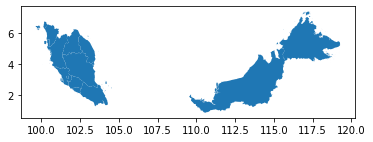

In [9]:
malaysia_map.plot()

In [10]:
malaysia_map.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,10.541451,1.556311,Johor,MY01,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((103.42134 1.30583, 103.42113 1..."
1,8.615689,0.777377,Kedeh,MY02,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((100.32889 5.66444, 100.32917 5..."
2,7.185704,1.234524,Kelantan,MY03,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((102.17395 6.20126, 102.17395 6..."
3,2.067451,0.134483,Melaka,MY06,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((102.33500 2.04833, 102.33528 2..."
4,3.620969,0.542415,Negeri,MY07,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((101.79472 2.51389, 101.79444 2..."


In [11]:
crs = {'init': 'epsg:4326'}

In [12]:
vax_school.head()

,code,school,state,district,postcode,lat,lon,dose1_staff,dose2_staff,dose1_student,dose2_student,dose1_12,dose1_13,dose1_14,dose1_15,dose1_16,dose1_17,dose1_18,dose2_12,dose2_13,dose2_14,dose2_15,dose2_16,dose2_17,dose2_18
0,ABA0001,SK TOH TANDEWA SAKTI,8,56,35000,4.196633,101.255932,100.0,100.0,69.6,0.0,68.8,100.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,ABA0002,SK PENDITA ZA'BA,8,56,35400,4.178276,101.200617,100.0,100.0,66.2,0.0,66.2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ABA0003,SK BANIR,8,56,35400,4.204361,101.181893,100.0,100.0,50.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ABA0004,SK TEMOH,8,56,35350,4.235841,101.172819,100.0,100.0,77.8,5.6,77.8,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN,NaN,NaN,NaN
4,ABA0005,SK CHENDERIANG,8,56,35300,4.267980,101.240556,100.0,100.0,78.4,0.0,78.4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


1 - Johor, 2 - Kedah, 3 - Kelantan, 4 - Melaka, 5 - Negeri Sembilan, 6 - Pahang, 7 - Pulau Pinang, 8 - Perak, 9 - Perlis, 10 - Selangor, 11 - Terengganu, 12 - Sabah, 13 - Sarawak, 14 - W.P. Kuala Lumpur, 15 - W.P. Labuan, 16 - W.P. Putrajaya

In [16]:
# check schools from Putrajaya, uncomment to see
# vax_school[vax_school['state'] == 16].head()

In [18]:
vax_school['state'] = vax_school['state'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], ['Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Pulau Pinang', 'Perak', 'Perlis', 'Selangor', 'Terengganu', 'Sabah', 'Sarawak', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya'])

In [20]:
vax_school['state'].unique()

array(['Perak', 'Selangor', 'Pahang', 'Kelantan', 'Johor', 'Kedah',
       'Melaka', 'Negeri Sembilan', 'Pulau Pinang', 'Perlis',
       'Terengganu', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya',
       'Sabah', 'Sarawak'], dtype=object)

In [21]:
vax_school.isna().sum()

code                0
school              0
state               0
district            0
postcode            0
lat                 0
lon                 0
dose1_staff         0
dose2_staff         0
dose1_student      43
dose2_student      43
dose1_12         1691
dose1_13         6665
dose1_14         7241
dose1_15         7665
dose1_16         7803
dose1_17         7799
dose1_18         8361
dose2_12         1691
dose2_13         6665
dose2_14         7241
dose2_15         7665
dose2_16         7803
dose2_17         7799
dose2_18         8361
dtype: int64

We can see that 43 schools listed there does not have any information regarding doses taken by student. Since it's only 0.43% of the row is incomplete, we have decided to drop the data with null value on students.

We did not drop rows that has null values on the other column such as dose1_12 and dose2_12, as not all school do have students at that age enrolls there. (Namely SK only has students around age 7-12)

In [23]:
vax_school.dropna(subset = ["dose1_student"], inplace=True)

In [25]:
geometry = [Point(xy) for xy in zip(vax_school['lon'], vax_school['lat'])]
geometry[:3]

In [26]:
geo_df = gpd.GeoDataFrame(vax_school, crs=crs, geometry=geometry)
geo_df.head()

C:\Users\ianch\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,code,school,state,district,postcode,lat,lon,dose1_staff,dose2_staff,dose1_student,dose2_student,dose1_12,dose1_13,dose1_14,dose1_15,dose1_16,dose1_17,dose1_18,dose2_12,dose2_13,dose2_14,dose2_15,dose2_16,dose2_17,dose2_18,geometry
0,ABA0001,SK TOH TANDEWA SAKTI,Perak,56,35000,4.196633,101.255932,100.0,100.0,69.6,0.0,68.8,100.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,POINT (101.25593 4.19663)
1,ABA0002,SK PENDITA ZA'BA,Perak,56,35400,4.178276,101.200617,100.0,100.0,66.2,0.0,66.2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,POINT (101.20062 4.17828)
2,ABA0003,SK BANIR,Perak,56,35400,4.204361,101.181893,100.0,100.0,50.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,POINT (101.18189 4.20436)
3,ABA0004,SK TEMOH,Perak,56,35350,4.235841,101.172819,100.0,100.0,77.8,5.6,77.8,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN,NaN,NaN,NaN,POINT (101.17282 4.23584)
4,ABA0005,SK CHENDERIANG,Perak,56,35300,4.267980,101.240556,100.0,100.0,78.4,0.0,78.4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,POINT (101.24056 4.26798)


<AxesSubplot:>

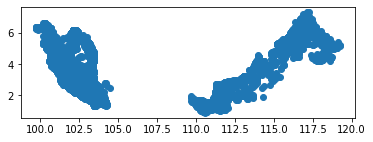

In [30]:
geo_df['geometry'].plot(aspect=1)

In [31]:
malaysia_map

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,10.541451,1.556311,Johor,MY01,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((103.42134 1.30583, 103.42113 1..."
1,8.615689,0.777377,Kedeh,MY02,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((100.32889 5.66444, 100.32917 5..."
2,7.185704,1.234524,Kelantan,MY03,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((102.17395 6.20126, 102.17395 6..."
3,2.067451,0.134483,Melaka,MY06,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((102.33500 2.04833, 102.33528 2..."
4,3.620969,0.542415,Negeri,MY07,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((101.79472 2.51389, 101.79444 2..."
5,10.750731,2.919169,Pahang,MY08,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((103.45879 3.46532, 103.45823 3..."
6,11.358448,1.707114,Perak,MY09,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((100.10291 3.97632, 100.10300 3..."
7,1.361590,0.067320,Perlis,MY10,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"POLYGON ((100.12444 6.40509, 100.12567 6.40631..."
8,2.616795,0.086223,Pulau Pinang,MY11,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((100.17973 5.23083, 100.18000 5..."
9,38.328468,6.028039,Sabah,MY12,None,None,None,Malaysia,MY,2020-12-02,2021-02-11,None,"MULTIPOLYGON (((118.62939 4.11226, 118.62906 4..."


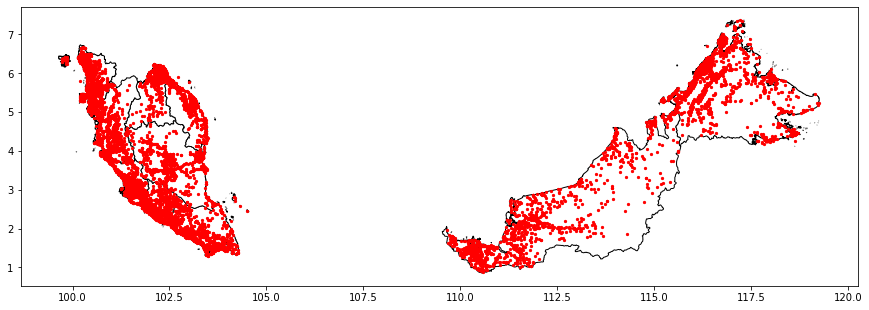

In [32]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')

malaysia_map.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

The map above shows the distribution of schools in Malaysia (shown as red dots).

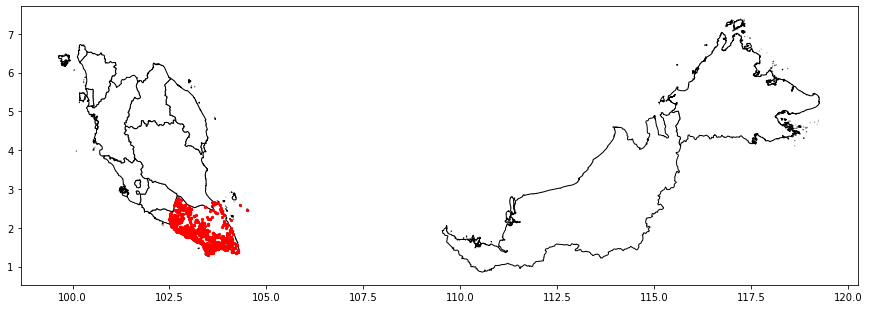

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')

malaysia_map.plot(ax=ax, color='white', edgecolor='black')
geo_df[geo_df['state'] == 'Johor'].plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

### Mean vaccination rate in schools amongst students and staffs

To evaluate how safe it is if the school reopens, we considered looking at the vaccination rate at each schools for staffs and students. We would look at the mean percentage by states, as schools would reopen by states.

In [35]:
vax_school_trim = vax_school.groupby('state', as_index=False).mean()
vax_school_trim

,state,district,postcode,lat,lon,dose1_staff,dose2_staff,dose1_student,dose2_student,dose1_12,dose1_13,dose1_14,dose1_15,dose1_16,dose1_17,dose1_18,dose2_12,dose2_13,dose2_14,dose2_15,dose2_16,dose2_17,dose2_18
0,Johor,4.663567,83273.090448,1.871637,103.306228,98.789096,97.875148,75.375063,7.295351,71.399702,90.526835,93.192722,95.930970,96.869504,97.803571,97.936441,1.459921,3.543349,3.532075,5.275746,47.165248,48.625000,84.924153
1,Kedah,15.278667,7806.230667,5.863783,100.491550,98.611333,97.647200,77.353467,10.798533,73.683468,90.794444,91.833721,93.708629,96.630846,97.129353,96.404459,2.170502,6.583681,6.993798,8.796954,67.294527,71.342289,90.959873
2,Kelantan,28.251678,16905.781879,5.846821,102.194673,98.486074,97.555537,73.380369,10.148658,67.467804,87.378188,85.026957,93.735776,94.921143,96.346591,96.639655,2.149680,16.030537,2.854348,28.650431,54.300000,59.311932,87.006034
3,Melaka,35.114650,76541.592357,2.287706,102.274664,99.110191,98.680255,78.734713,11.257006,73.843678,96.384459,95.714000,97.653333,97.444737,98.202632,97.580645,4.341762,24.537838,9.047000,47.793333,42.153947,41.761842,91.282258
4,Negeri Sembilan,40.463158,71729.250526,2.703546,102.115100,98.883789,98.401684,62.933263,8.924632,54.041253,88.326636,92.681429,97.396667,96.858871,97.453226,96.705319,2.265013,24.620093,4.713571,37.708333,46.272581,47.893548,85.350000
5,Pahang,49.282225,27866.971506,3.664863,102.575915,98.891588,98.105699,75.018589,11.657666,69.073846,90.679495,91.046748,95.665126,96.186364,97.311675,98.604724,1.086838,15.920820,6.036585,24.140336,82.452020,82.930964,93.717323
6,Perak,60.772187,33531.134492,4.539639,100.949010,98.476029,97.532296,74.874016,8.849131,70.600437,88.360665,90.553623,93.163158,96.335081,97.476613,96.625854,1.257268,2.384765,2.281739,3.427530,68.699194,72.248387,87.131220
7,Perlis,67.000000,1975.480769,6.452178,100.224524,98.374038,97.255769,78.136538,11.350000,72.935714,93.638235,92.106667,95.856667,97.000000,98.090000,96.552174,1.882143,0.885294,1.346667,4.873333,84.703333,73.990000,90.430435
8,Pulau Pinang,70.386935,12640.175879,5.379311,100.380213,98.860553,97.893719,78.731156,7.077387,74.164169,88.758553,91.870229,93.380000,95.426400,95.727559,97.350549,0.761889,2.047368,2.824427,2.370000,31.588000,34.809449,82.841758
9,Sabah,85.858249,89723.615802,5.648841,116.825116,97.794655,96.231139,81.213943,52.096437,79.518310,85.306538,88.784649,90.684651,91.935616,93.375455,94.243275,49.216197,60.208462,66.658772,66.937674,74.435160,78.201818,87.040936


### Students

<AxesSubplot:xlabel='dose1_student', ylabel='state'>

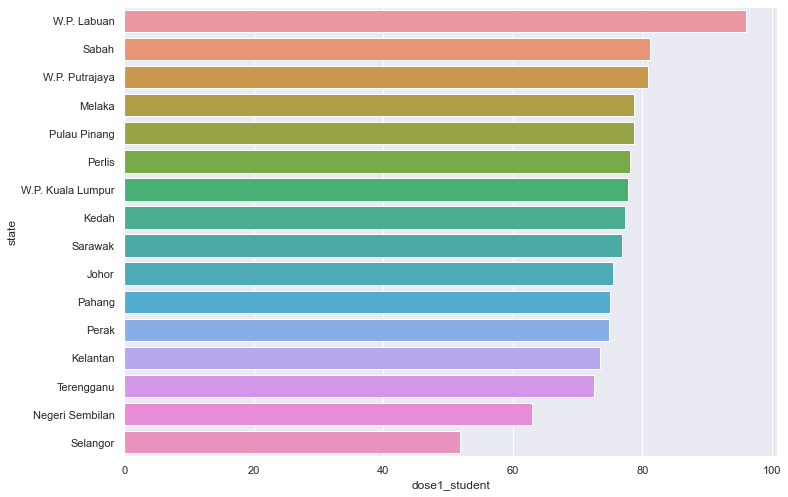

In [36]:
vax_school_trim = vax_school_trim.sort_values('dose1_student', ascending=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=vax_school_trim, x='dose1_student', y='state', orient='h')
#sns.factorplot(x='state', y='dose1_student', data=df)

<AxesSubplot:xlabel='dose2_student', ylabel='state'>

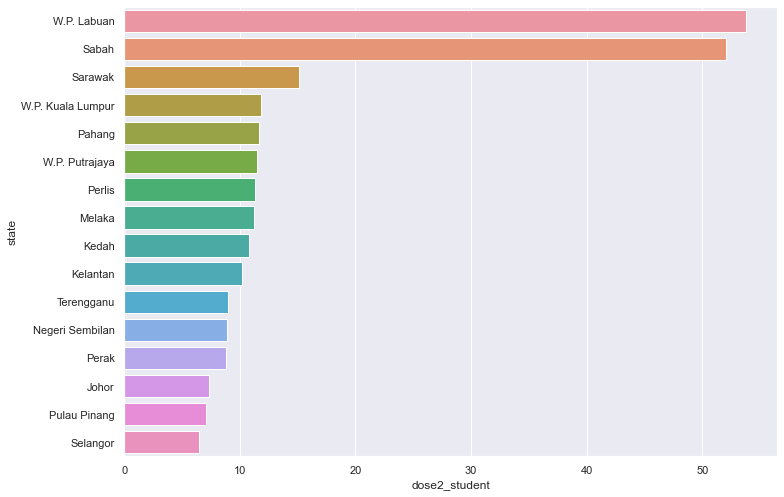

In [38]:
vax_school_trim = vax_school_trim.sort_values('dose2_student', ascending=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=vax_school_trim, x='dose2_student', y='state', orient='h')

We can see that most of the students (>70%) have at least taken their first dose for all states. However, only W.P. Labuan have a high rate of full vaccinations for students (>50%), with more than half of the states having only close to or still less than 10% of their students fully vaccinated.

### Staffs

<AxesSubplot:xlabel='dose1_staff', ylabel='state'>

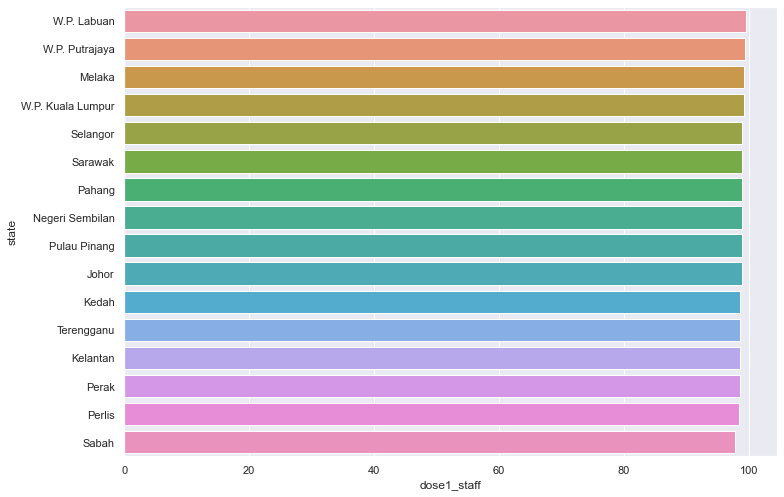

In [40]:
vax_school_trim = vax_school_trim.sort_values('dose1_staff', ascending=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=vax_school_trim, x='dose1_staff', y='state', orient='h')

<AxesSubplot:xlabel='dose2_staff', ylabel='state'>

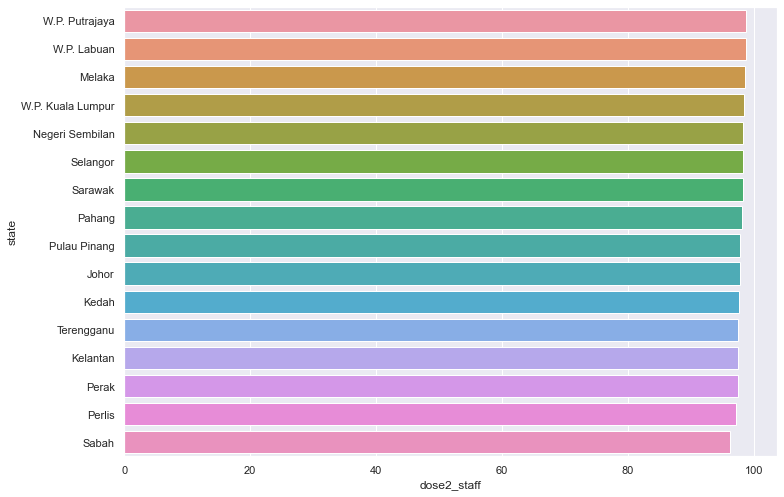

In [42]:
vax_school_trim = vax_school_trim.sort_values('dose2_staff', ascending=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=vax_school_trim, x='dose2_staff', y='state', orient='h')

We can see that most of the staffs (>90%) have completed their vaccination.

# EDA on CITF Dataset

## Loading Dataset

In [43]:
# Registration
vaxreg_malaysia = pd.read_csv('citf-public/registration/vaxreg_malaysia.csv')
vaxreg_state = pd.read_csv('citf-public/registration/vaxreg_state.csv')

vaxreg_malaysia['date'] = pd.to_datetime(vaxreg_malaysia['date'], errors='raise')
vaxreg_state['date'] = pd.to_datetime(vaxreg_state['date'], errors='raise')

# vaccination 
vax_malaysia = pd.read_csv('citf-public/vaccination/vax_malaysia.csv')
vax_state = pd.read_csv('citf-public/vaccination/vax_state.csv')

vax_malaysia['date'] = pd.to_datetime(vax_malaysia['date'], errors='raise')
vax_state['date'] = pd.to_datetime(vax_state['date'], errors='raise')

In [44]:
vaxreg_malaysia.head()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
1,2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2,2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
3,2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
4,2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623


In [45]:
vaxreg_state.head()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Johor,2024149,657731,1880609,1167,142373,94096,373226,477510,39807
1,2021-06-24,Kedah,938187,340264,850376,855,86956,39636,181729,264154,20150
2,2021-06-24,Kelantan,621203,223260,527284,426,93493,26305,119608,173570,12921
3,2021-06-24,Melaka,510641,179964,484164,436,26041,25638,98045,138618,13547
4,2021-06-24,Negeri Sembilan,633026,229995,591847,592,40587,32396,125029,179280,13902


In [46]:
vax_malaysia.head()

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,0,60,0,60,0,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1146,0,1146,0,0,0,1206,0,1206,0,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,4115,1,4116,0,0,0,5321,1,5322,0,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,6723,1,6724,0,0,0,12044,2,12046,0,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,6699,3,6702,0,0,0,18743,5,18748,0,0,0,6699,3,0,0,0,0,0,0


In [47]:
vax_state.head()

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Vaccination Registration Data

In [48]:
vaxreg_malaysia.dtypes

date        datetime64[ns]
state               object
total                int64
phase2               int64
mysj                 int64
call                 int64
web                  int64
children             int64
elderly              int64
comorb               int64
oku                  int64
dtype: object

In [50]:
vaxreg_malaysia.isnull().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [51]:
analysis = vaxreg_malaysia.copy()
analysis.set_index('date', inplace=True)
analysis.head()

,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
date,,,,,,,,,,
2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623


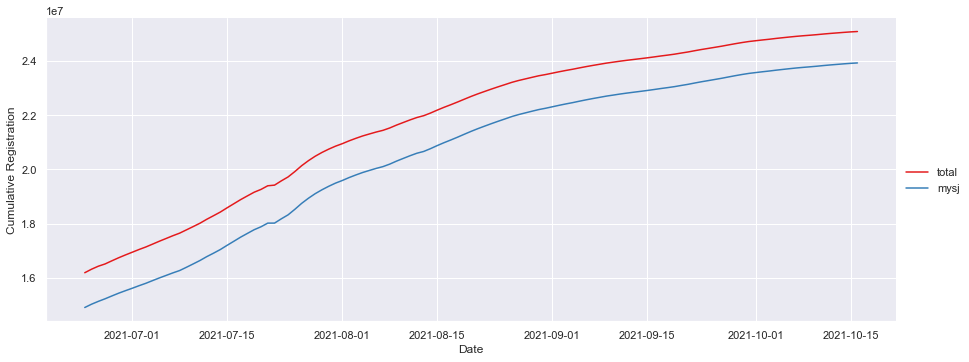

In [52]:
ax = sns.relplot(data=analysis.loc[:,['total', 'mysj']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')
#ax.axhline(population['pop'][0], ls='--', linewidth=3, color='red')
# ax = ax.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'COUNT')
#ax.refline(y=population['pop'][0])

#ax.axhline()

ax.set_xlabels('Date')
ax.set_ylabels('Cumulative Registration')

In [53]:
analysis.head()

,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
date,,,,,,,,,,
2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623


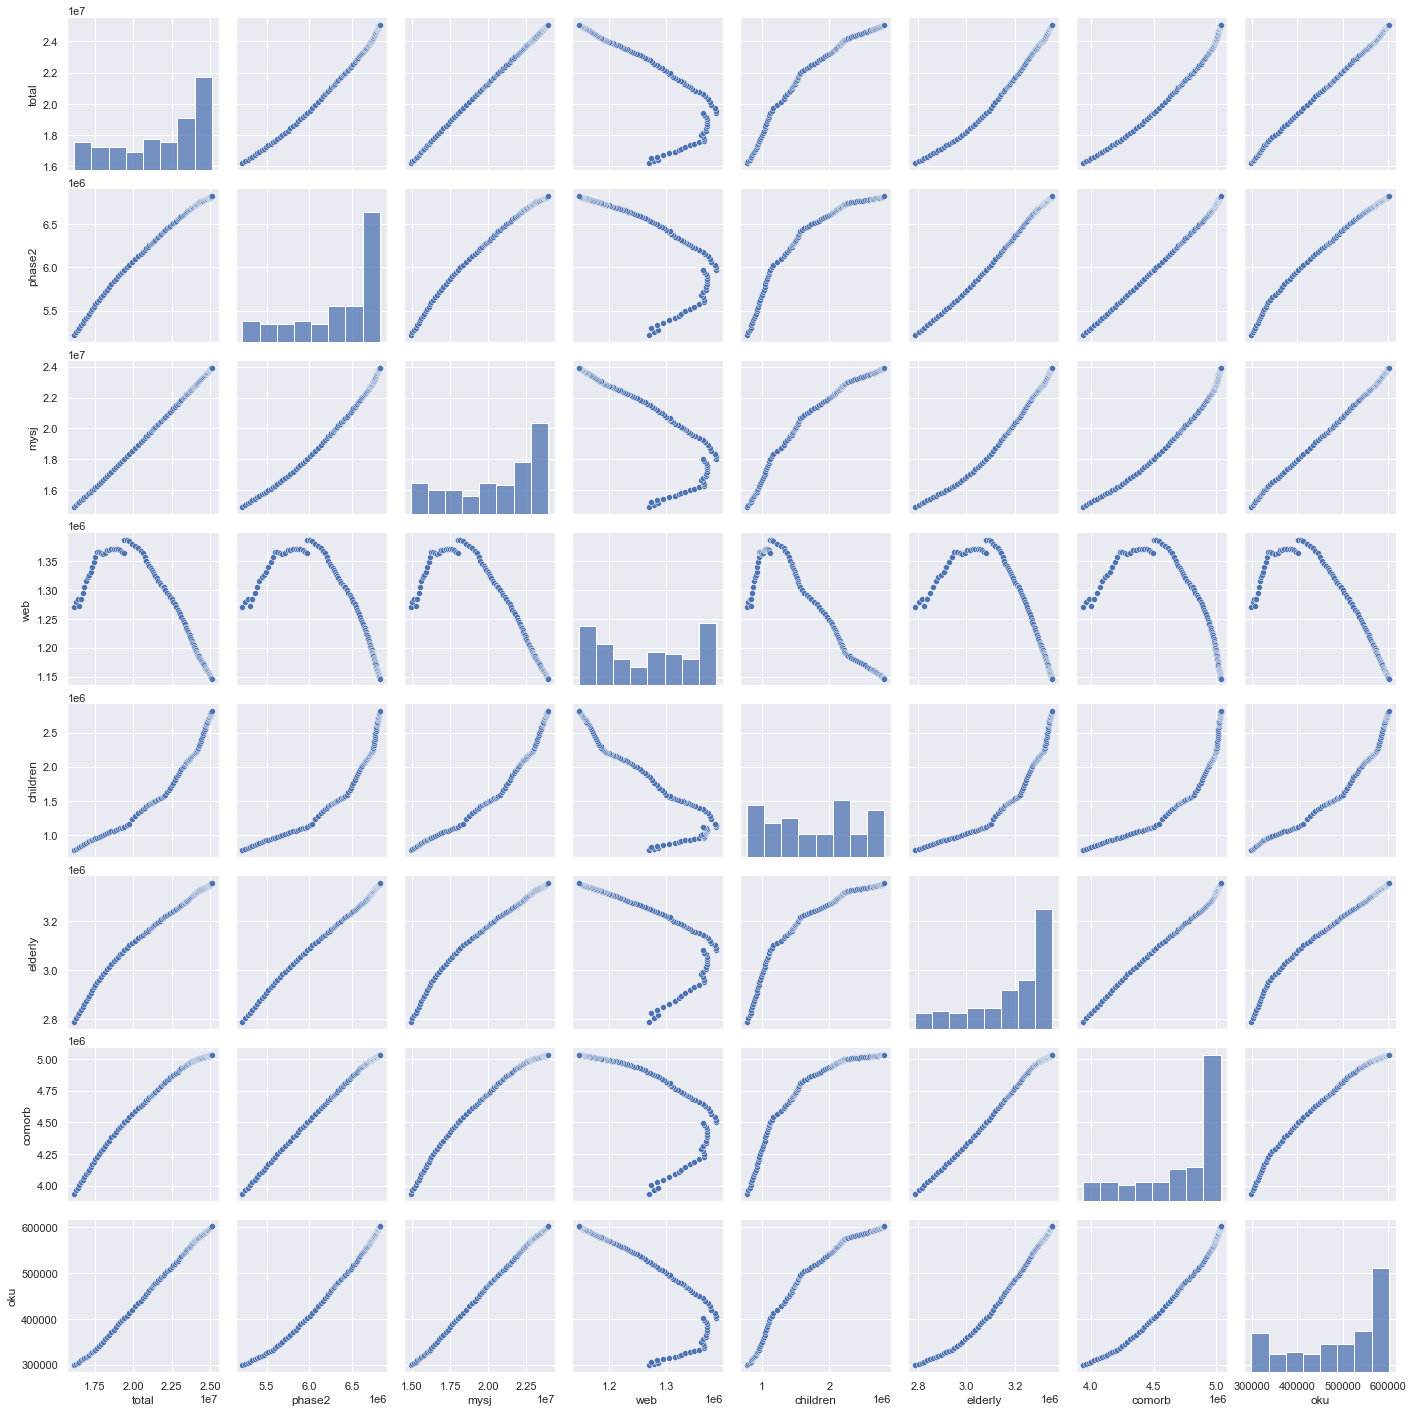

In [54]:
sns.pairplot(data=analysis[['state', 'total', 'phase2', 'mysj', 'web', 'children', 'elderly', 'comorb', 'oku']])

In [55]:
analysis['daily_reg'] = analysis['total'].diff()
analysis['7_rolling_avg'] = analysis['daily_reg'].rolling(7).mean()

In [56]:
analysis.dropna(inplace=True)

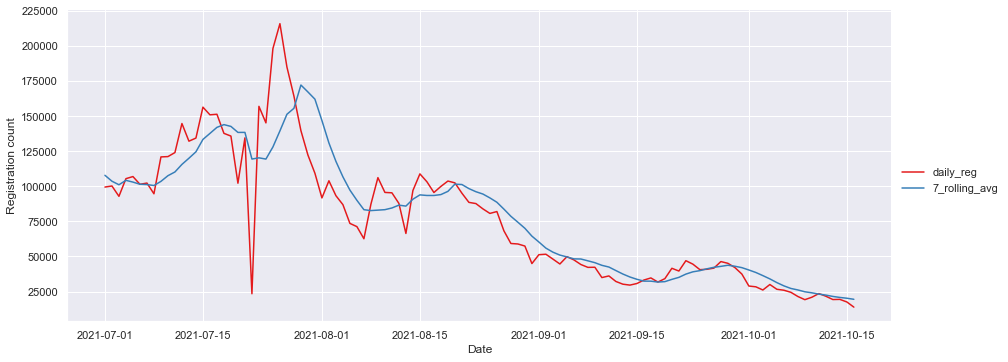

In [57]:
ax = sns.relplot(data=analysis.loc[:,['daily_reg', '7_rolling_avg']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')
#ax.axhline(population['pop'][0], ls='--', linewidth=3, color='red')
# ax = ax.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'COUNT')
#ax.refline(y=population['pop'][0])

#ax.axhline()
ax.set_xlabels('Date')
ax.set_ylabels('Registration count')

There's a significant drop around late July 2021 for the registration, though the number spikes back up few days after. We are unable to ascertain why, but we assume there might be a downtime or significant deduplication happening during that time period.

<AxesSubplot:>

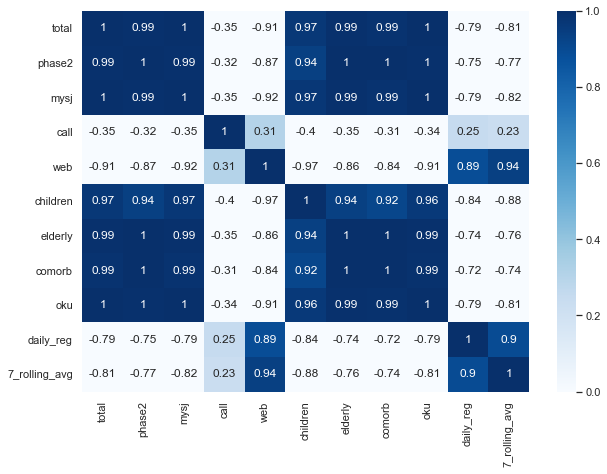

In [58]:
columns_list = analysis.columns
columns_list = columns_list.delete(0)

#analysis.groupby('ID')[['Val1','Val2']].corr()
sns.set(rc={'figure.figsize':(10, 7)})
sns.heatmap(analysis[columns_list].corr(), cmap='Blues', annot=True, vmin=0, vmax=1)

In [59]:
#analysis_recent = vaxreg_malaysia.copy()
analysis_recent = vaxreg_malaysia.iloc[-1:]


analysis_recent = pd.merge(analysis_recent, population[['state', 'pop','pop_18', 'pop_60', 'pop_12']], on='state')
#analysis_recent['pop_18'] = population['pop_18'][0]
#analysis_recent['pop_60'] = population['pop_60'][0]

analysis_recent

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku,pop,pop_18,pop_60,pop_12
0,2021-10-16,Malaysia,25079220,6820116,23921547,11100,1146573,2814172,3355115,5032753,601552,32657400,23409600,3502000,3147500


In [60]:
analysis_recent['num_in_between'] = (analysis_recent['total'] - analysis_recent['children'] - analysis_recent['elderly'])
# #analysis_recent['pop_between'] = analysis_recent['pop'] - analysis_recent['pop_18'] - analysis_recent['pop_60']

analysis_recent['percent_children'] = ((analysis_recent['children'] / analysis_recent['pop_12']) * 100).round(2)
analysis_recent['percent_elderly'] = ((analysis_recent['elderly'] / analysis_recent['pop_60']) * 100).round(2)
analysis_recent['percent_adults'] = (((analysis_recent['num_in_between']) / (analysis_recent['pop_18'])) * 100).round(2)

analysis_recent

# ======================
# analysis_recent['num_in_between'] = (analysis_recent['total'] - analysis_recent['children'] - analysis_recent['elderly'])
# #analysis_recent['pop_between'] = analysis_recent['pop'] - analysis_recent['pop_18'] - analysis_recent['pop_60']

# analysis_recent['percent_children'] = ((analysis_recent['children'] / analysis_recent['pop_12']) * 100).round(2)
# analysis_recent['percent_reg_60'] = ((analysis_recent['elderly'] / analysis_recent['pop_60']) * 100).round(2)
# analysis_recent['percent_in_between'] = (((analysis_recent['num_in_between']) / (analysis_recent['pop'] - analysis_recent['pop_18'] - analysis_recent['pop_60'])) * 100).round(2)
# ==================

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku,pop,pop_18,pop_60,pop_12,num_in_between,percent_children,percent_elderly,percent_adults
0,2021-10-16,Malaysia,25079220,6820116,23921547,11100,1146573,2814172,3355115,5032753,601552,32657400,23409600,3502000,3147500,18909933,89.41,95.81,80.78


Do childrens (<18) somehow got themselves registered as adults? Is there possible duplications that did not get resolved, or immigrants registered for vaccination here in this country counted as such? Latter seems likely, but that implies a huge amount of non-Malaysian registered for the vaccines.

Here we can see that up to 16th October, only 10% of population under 18 years old have registered for the vaccine, and the number seems rather low, considering the phase 4 of Recovery Plan is approaching and [students are expected to come back to the school in November 2021](https://www.thestar.com.my/news/nation/2021/09/12/education-minister-tighter-sop-for-schools-ahead-of-oct-3-reopening) . From what we can see, at least more than 80% at each category (children, adults, elderly) have registered for mysejahtera. More than 87% of the children under 18 have registered for the vaccine, which is above the required for herd immunity and ahead of the school reopening time.

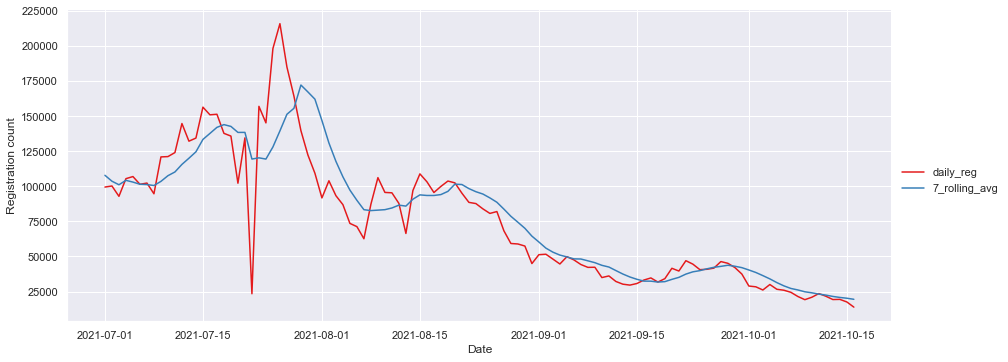

In [61]:
ax = sns.relplot(data=analysis.loc[:,['daily_reg', '7_rolling_avg']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')
#ax.axhline(population['pop'][0], ls='--', linewidth=3, color='red')
# ax = ax.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'COUNT')
#ax.refline(y=population['pop'][0])

#ax.axhline()
ax.set_xlabels('Date')
ax.set_ylabels('Registration count')

In [62]:
analysis_daily = vaxreg_malaysia.copy()
analysis_daily.columns

for x in analysis_daily.columns:
    if x == 'state' or x == 'date':
        continue
    analysis_daily[x] = analysis_daily[x].diff()
    
analysis_daily.dropna(inplace=True)

In [63]:
analysis_daily.head(5)

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
1,2021-06-25,Malaysia,129697.0,33787.0,121203.0,111.0,8383.0,20941.0,15054.0,25927.0,2932.0
2,2021-06-26,Malaysia,110539.0,29215.0,104491.0,113.0,5935.0,18063.0,12921.0,22163.0,2722.0
3,2021-06-27,Malaysia,83472.0,21625.0,95492.0,-84.0,-11936.0,14659.0,9070.0,16813.0,2169.0
4,2021-06-28,Malaysia,115568.0,29485.0,104172.0,125.0,11271.0,12342.0,10739.0,24140.0,2883.0
5,2021-06-29,Malaysia,112131.0,29482.0,101593.0,135.0,10403.0,13005.0,12957.0,22358.0,2930.0


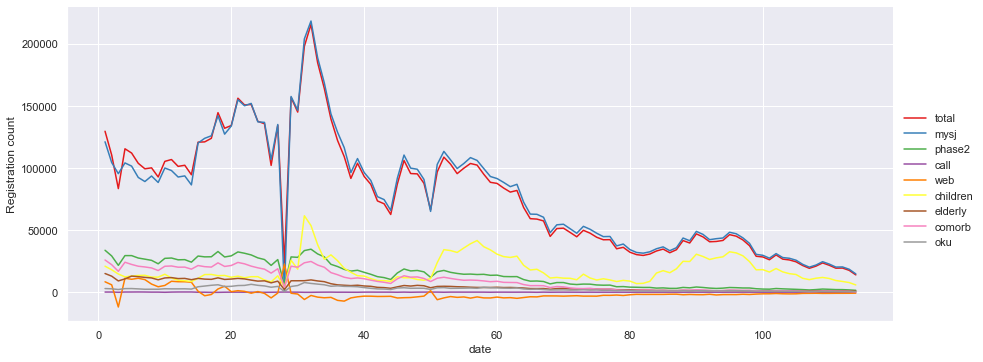

In [64]:
ax = sns.relplot(data=analysis_daily.loc[:,['total', 'mysj', 'phase2', 'call', 'web', 'children', 'elderly', 'comorb', 'oku']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')
#ax.axhline(population['pop'][0], ls='--', linewidth=3, color='red')
# ax = ax.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'COUNT')
#ax.refline(y=population['pop'][0])

#ax.axhline()
ax.set_xlabels('date')
ax.set_ylabels('Registration count')

From this graph, we can see that during the time when the total registration fell down, the number of registration for web increases, although it's only a small amount relative to the dip in mysejahtera registration during that day.

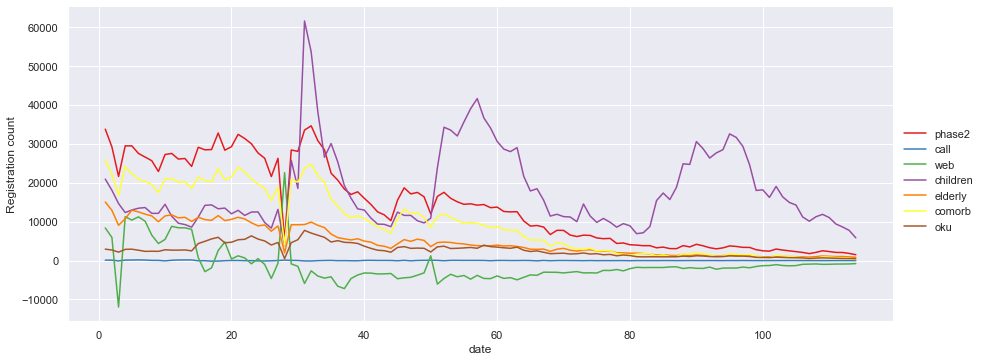

In [65]:
ax = sns.relplot(data=analysis_daily.loc[:,['phase2', 'call', 'web', 'children', 'elderly', 'comorb', 'oku']], kind='line',
            aspect=2.5, dashes=False, palette='Set1')
#ax.axhline(population['pop'][0], ls='--', linewidth=3, color='red')
# ax = ax.map(lambda y, **kw: plt.axhline(y.mean(), color="k"), 'COUNT')
#ax.refline(y=population['pop'][0])

#ax.axhline()
ax.set_xlabels('date')
ax.set_ylabels('Registration count')

We can that from this graph that somehow web registration goes into negative numbers. As noted in README.md for registration, MySejahtera has higher priority in the deduplication process, followed by call and then WEB registration. From this, we can assume that a lot of users registered for their vaccines through both MySejahtera and the website, and since the MySejahtera application takes priority over the web, a lot of web registration got deleted in the process.

In [66]:
vax_state.head()

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

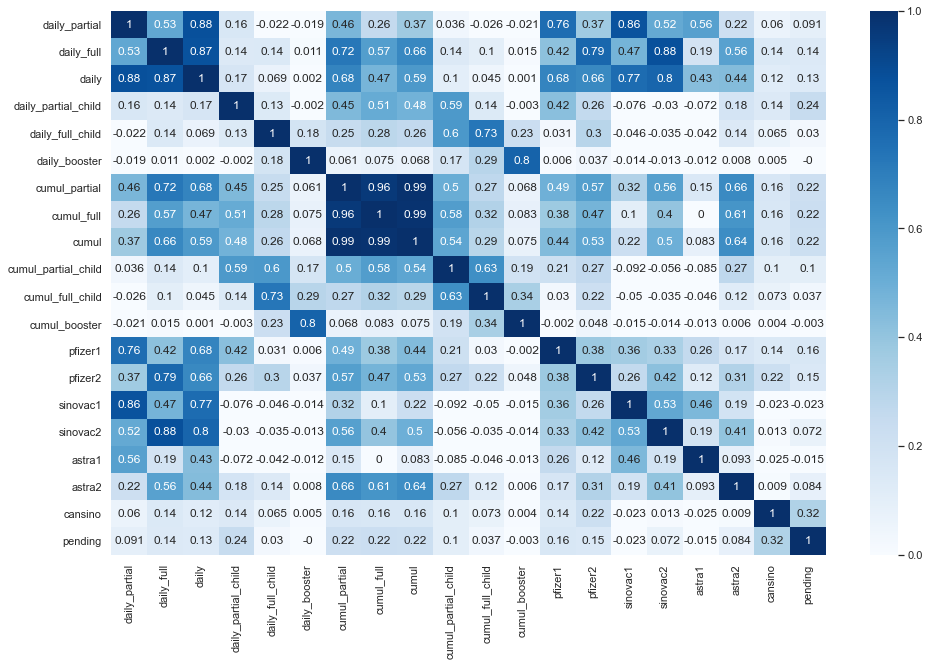

In [70]:
analysis = vax_state.copy()
columns_list = analysis.columns
columns_list = columns_list.delete(0)

#analysis.groupby('ID')[['Val1','Val2']].corr()
sns.set(rc={'figure.figsize':(16, 10)})
sns.heatmap(analysis[columns_list].corr().round(3), cmap='Blues', annot=True, vmin=0, vmax=1)

## For vaccination doses per state

First, we would look at the cumulative doses given in each state, sorted by descending order

In [71]:
vax_state_trim = vax_state.iloc[-16:]
vax_state_trim = vax_state_trim.sort_values('cumul', ascending=False)

<AxesSubplot:xlabel='cumul', ylabel='state'>

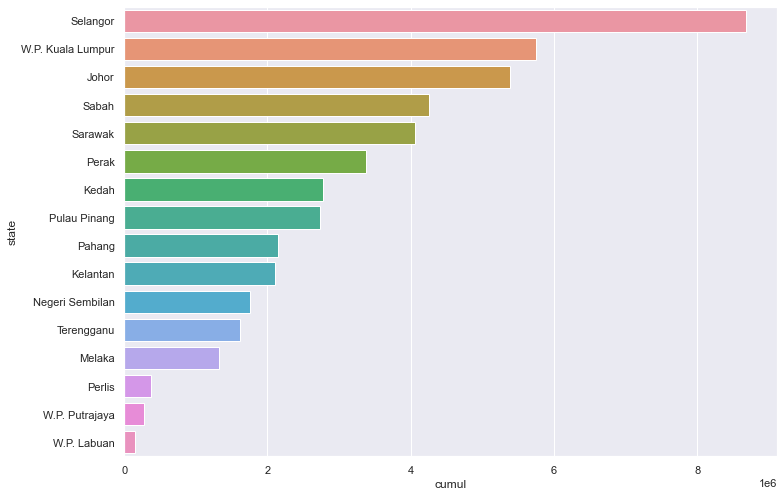

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=vax_state_trim, x='cumul', y='state', orient='h')

From here, we can see that Selangor has the most vaccine dose given compared all of the states

In [73]:
states_pop = population.iloc[-16:]

In [75]:
df_temp = pd.merge(vax_state_trim, population[['state', 'pop','pop_18', 'pop_60', 'pop_12']], on='state')

df_temp['perc_vax'] = (df_temp['cumul_partial'] / df_temp['pop'] * 100).round(2)

In [76]:
df_temp

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,pop,pop_18,pop_60,pop_12,perc_vax
0,2021-10-16,Selangor,5179,8555,13734,4617,7628,0,4564507,4118218,8678188,383538,56690,57,4721,8134,320,382,0,0,0,177,6538000,4747900,575800,569100,69.82
1,2021-10-16,W.P. Kuala Lumpur,1105,6798,7903,585,5558,0,2971904,2781658,5753298,138468,28353,106,950,6452,135,320,0,0,13,33,1773700,1348600,205800,140800,167.55
2,2021-10-16,Johor,3261,16231,19518,2530,7253,26,2873099,2516534,5386238,310300,54932,26,2891,8376,354,871,0,6909,35,82,3781000,2711900,428700,359900,75.99
3,2021-10-16,Sabah,1538,13200,14738,599,7471,0,2299290,2037946,4255323,253087,177003,0,1420,12350,113,134,1,391,285,44,3908500,2758400,238900,434000,58.83
4,2021-10-16,Sarawak,833,18254,21284,328,17810,2197,2106804,1938676,4054567,230833,101830,9383,2940,18047,89,206,0,0,0,2,2816500,2042700,332800,293200,74.80
5,2021-10-16,Perak,279,11451,12659,161,5971,929,1782140,1590388,3372199,194943,57840,7397,1140,9328,64,52,0,1921,131,23,2510300,1862700,397300,237200,70.99
6,2021-10-16,Kedah,426,6623,7050,198,4535,1,1478979,1305269,2780551,186479,53277,258,373,5232,45,2,1,1341,33,23,2185100,1540600,272500,211400,67.68
7,2021-10-16,Pulau Pinang,1198,9009,10216,590,5189,9,1448170,1283201,2727865,123022,18156,9,936,5745,252,498,5,2723,0,57,1773600,1367200,239200,141500,81.65
8,2021-10-16,Pahang,80,3921,4008,22,3278,7,1132167,1011665,2141309,132644,45674,1075,81,3528,6,29,0,360,0,4,1678700,1175800,190200,173000,67.44
9,2021-10-16,Kelantan,402,4083,4496,198,3524,11,1141296,968286,2107439,161125,40242,204,329,3927,84,151,0,0,0,5,1906700,1236200,194100,210600,59.86


Note that cumul_partial is used to count the number of unique individuals who have been vaccinated, which compromises people who received 1 dose of a double-dose vaccine (such as Pfizer, Sinovac, AstraZec), and those who received a single-dose vaccine (cansino).

Text(0.5, 1.0, 'Numbers of invidual that has been vaccinated (partial/complete)')

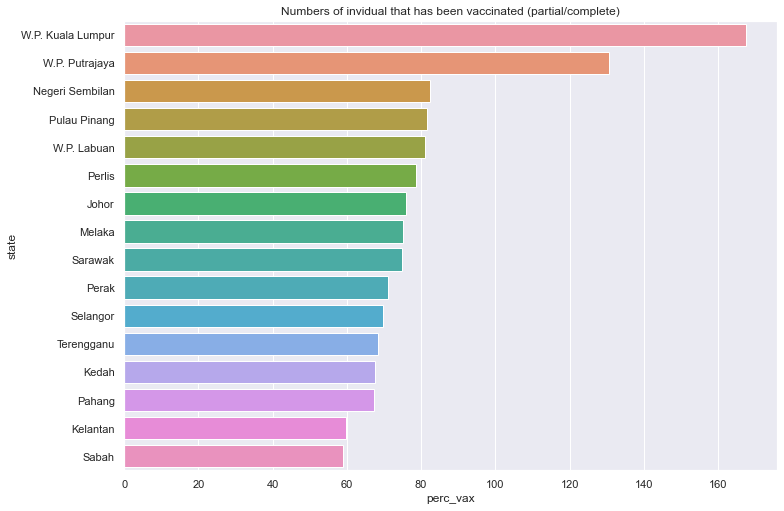

In [77]:
df_temp = df_temp.sort_values('perc_vax', ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(data=df_temp, x='perc_vax', y='state', orient='h')
ax.set_title('Numbers of invidual that has been vaccinated (partial/complete)')

From this bar chart, we can see that more than 100% of the population in W.P. Kuala Lumpur have gotten their vaccines. We assumed that people from different states may have taken their vaccines in Kuala Lumpur during the vaccination drive.

## Vaccination Progress

### Vaccination Progress in Malaysia

In [78]:
df_trim = vax_malaysia.iloc[-1:]
df_trim = df_trim.sort_values('cumul', ascending=False)

df_trim['pop'] = population['pop'][0]
df_trim

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,pop
234,2021-10-16,15421,109745,128347,10625,79253,3181,24715782,22146626,46761751,2450352,716332,18766,16867,92625,1497,2688,7,13710,497,456,32657400


Calculate the percentages of population having vaccinated at least once

In [79]:
df_trim['percent_complete_part'] = ((df_trim['cumul_partial'] / df_trim['pop']) * 100).round(2)
df_trim['percent_incomplete_part'] = 100 - df_trim['percent_complete_part']
df_trim['place'] = 'Malaysia'

<AxesSubplot:xlabel='place'>

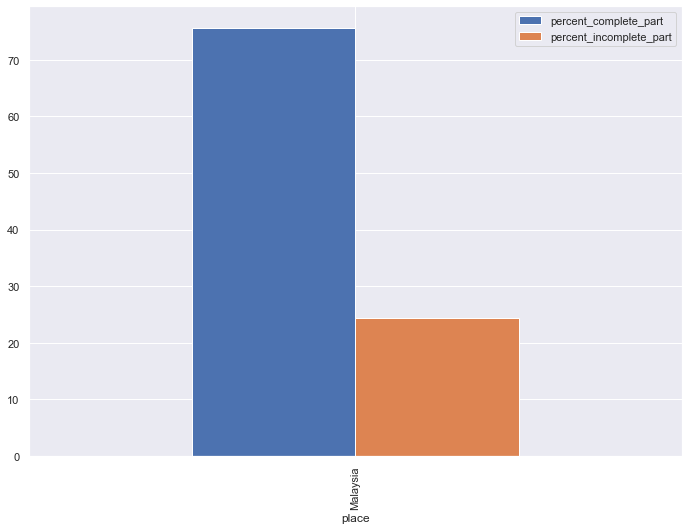

In [80]:
df_trim.plot(x="place", y=["percent_complete_part", "percent_incomplete_part"], kind="bar")

Here we can see that by 16th Oct 2021, about 3/4 of the Malaysian population have at least gotten their first vaccine.

In [81]:
df_trim

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,pop,percent_complete_part,percent_incomplete_part,place
234,2021-10-16,15421,109745,128347,10625,79253,3181,24715782,22146626,46761751,2450352,716332,18766,16867,92625,1497,2688,7,13710,497,456,32657400,75.68,24.32,Malaysia


In [82]:
df_trim['percent_complete_full'] = ((df_trim['cumul_full'] / df_trim['pop']) * 100).round(2)
df_trim['percent_incomplete_full'] = 100 - df_trim['percent_complete_full']

<AxesSubplot:xlabel='place'>

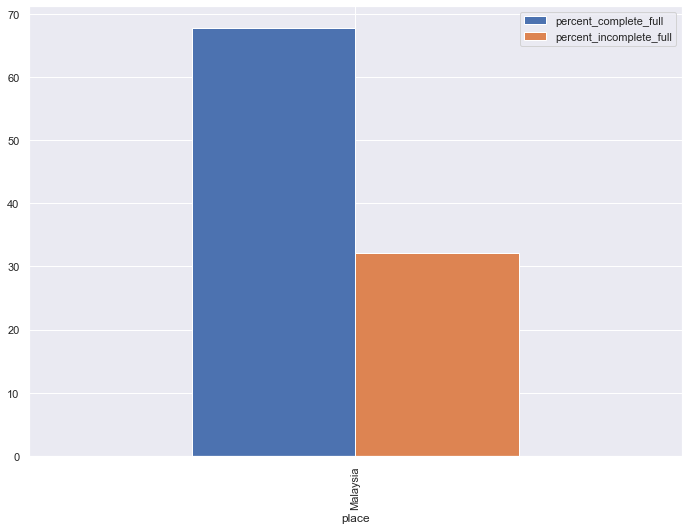

In [83]:
df_trim.plot(x="place", y=["percent_complete_full", "percent_incomplete_full"], kind="bar")

By this date, roughly 66% of people have completed their vaccination dose.

In [84]:
analysis = vax_state.copy()

In [85]:
analysis

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,daily_booster,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,cumul_booster,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,2021-10-16,Selangor,5179,8555,13734,4617,7628,0,4564507,4118218,8678188,383538,56690,57,4721,8134,320,382,0,0,0,177
3756,2021-10-16,Terengganu,675,3815,4490,608,3706,0,861416,752111,1609433,116743,29991,0,666,3811,9,4,0,0,0,0
3757,2021-10-16,W.P. Kuala Lumpur,1105,6798,7903,585,5558,0,2971904,2781658,5753298,138468,28353,106,950,6452,135,320,0,0,13,33
3758,2021-10-16,W.P. Labuan,61,706,767,8,660,0,80753,74097,154850,8112,5952,0,61,706,0,0,0,0,0,0


state
Johor                AxesSubplot(0.125,0.125;0.775x0.755)
Kedah                AxesSubplot(0.125,0.125;0.775x0.755)
Kelantan             AxesSubplot(0.125,0.125;0.775x0.755)
Melaka               AxesSubplot(0.125,0.125;0.775x0.755)
Negeri Sembilan      AxesSubplot(0.125,0.125;0.775x0.755)
Pahang               AxesSubplot(0.125,0.125;0.775x0.755)
Perak                AxesSubplot(0.125,0.125;0.775x0.755)
Perlis               AxesSubplot(0.125,0.125;0.775x0.755)
Pulau Pinang         AxesSubplot(0.125,0.125;0.775x0.755)
Sabah                AxesSubplot(0.125,0.125;0.775x0.755)
Sarawak              AxesSubplot(0.125,0.125;0.775x0.755)
Selangor             AxesSubplot(0.125,0.125;0.775x0.755)
Terengganu           AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Kuala Lumpur    AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Labuan          AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Putrajaya       AxesSubplot(0.125,0.125;0.775x0.755)
Name: cumul_partial, dtype: object

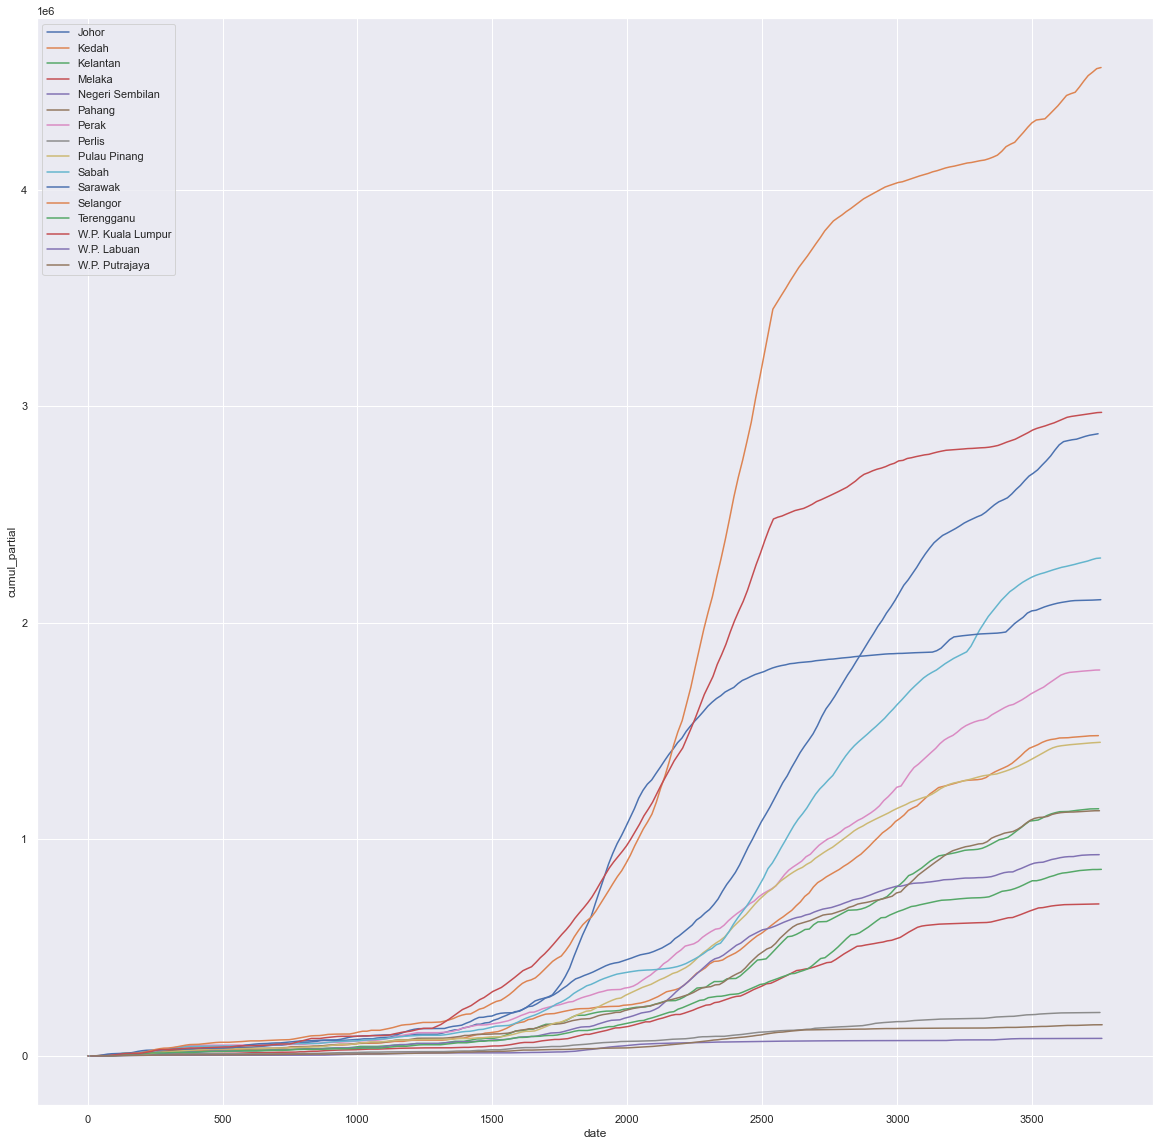

In [86]:
plt.figure(figsize=(20, 20))
#analysis.set_index("date", inplace=True)
analysis.groupby("state")["cumul_partial"].plot(legend=True, xlabel="date", ylabel="cumul_partial")

state
Johor                AxesSubplot(0.125,0.125;0.775x0.755)
Kedah                AxesSubplot(0.125,0.125;0.775x0.755)
Kelantan             AxesSubplot(0.125,0.125;0.775x0.755)
Melaka               AxesSubplot(0.125,0.125;0.775x0.755)
Negeri Sembilan      AxesSubplot(0.125,0.125;0.775x0.755)
Pahang               AxesSubplot(0.125,0.125;0.775x0.755)
Perak                AxesSubplot(0.125,0.125;0.775x0.755)
Perlis               AxesSubplot(0.125,0.125;0.775x0.755)
Pulau Pinang         AxesSubplot(0.125,0.125;0.775x0.755)
Sabah                AxesSubplot(0.125,0.125;0.775x0.755)
Sarawak              AxesSubplot(0.125,0.125;0.775x0.755)
Selangor             AxesSubplot(0.125,0.125;0.775x0.755)
Terengganu           AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Kuala Lumpur    AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Labuan          AxesSubplot(0.125,0.125;0.775x0.755)
W.P. Putrajaya       AxesSubplot(0.125,0.125;0.775x0.755)
Name: daily_partial, dtype: object

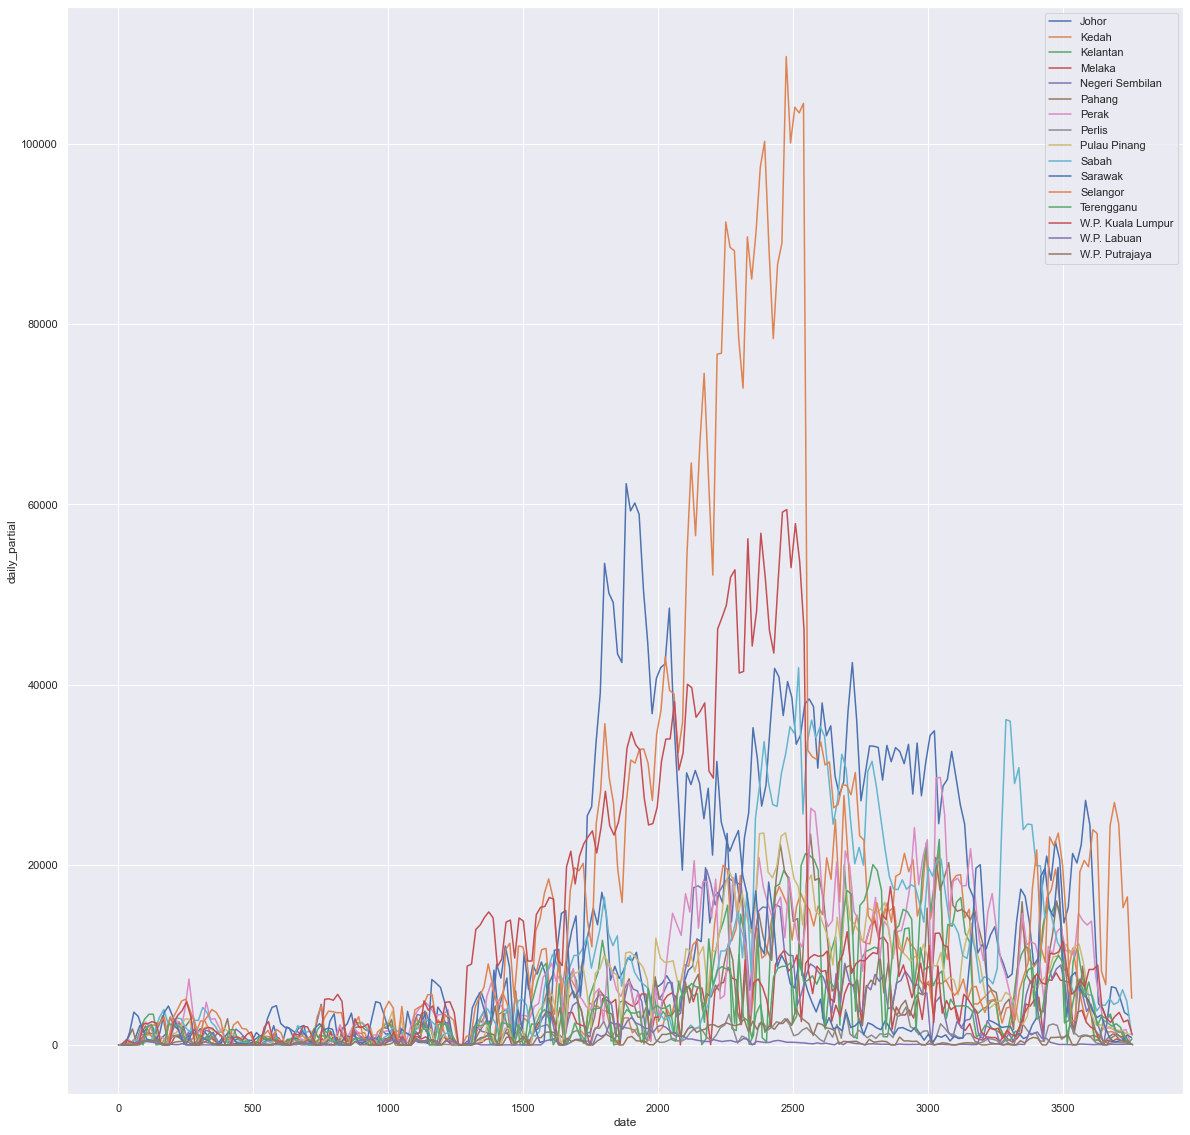

In [87]:
plt.figure(figsize=(20, 20))
#analysis.set_index("date", inplace=True)
analysis.groupby("state")["daily_partial"].plot(legend=True, xlabel="date", ylabel="daily_partial")

We can see there's a huge jump of vaccination given out at Selangor. For most of the other states, the vaccinations given daily is roughly around 20000.

# Mean Monthly Household Gross Income

## Loading the dataset

In [89]:
income = pd.read_csv('random_dataset/_202108260434240_mean-monthly-household-gross-income-by-state-malaysia.csv')

In [90]:
income.head(20)

,Country/State,Year,Mean Monthly Household Gross Income
0,Malaysia,2002,3011
1,Malaysia,2004,3249
2,Malaysia,2007,3686
3,Malaysia,2009,4025
4,Malaysia,2012,5000
5,Malaysia,2014,6141
6,Malaysia,2016,6958
7,Malaysia,2019,7901
8,Johor,2002,2963
9,Johor,2004,3076


In [91]:
income.tail(20)

,Country/State,Year,Mean Monthly Household Gross Income
133,W.P. Putrajaya,2014,10401
134,W.P. Putrajaya,2016,11555
135,W.P. Putrajaya,2019,12840
136,Malaysia,2020,7089
137,Johor,2020,7264
138,Kedah,2020,5005
139,Kelantan,2020,4411
140,Melaka,2020,7186
141,N.Sembilan,2020,6184
142,Pahang,2020,5144
